# Modules and Imports

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.preprocessing import PolynomialFeatures as pf
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from scipy.cluster import hierarchy
from sklearn.model_selection import cross_val_predict
import sklearn.model_selection as ms

import statsmodels.api as sm

import traces

from pandas.plotting import register_matplotlib_converters

import re

%matplotlib inline
plt.style.use('seaborn-whitegrid')

# Preparing FiveThirtyEight Data
We are only using polls from pollsters graded at least an A- by FiveThirtyEight
Grading criteria: https://fivethirtyeight.com/features/how-fivethirtyeight-calculates-pollster-ratings/

In [2]:
validPollsters = ["Marist College", "Monmouth University", "ABC News/The Washington Post", "Siena College/The New York Times Upshot", "Selzer & Co.", "Muhlenberg College", "SurveyUSA", "Suffolk University", "CBS News/The New York Times", "Emerson College", "Siena College", "Fox News/Beacon Research/Shaw & Co. Research", "RKM Research and Communications Inc.", "NBC News/The Wall Street Journal"]

In [3]:
fte = pd.read_csv("data/president_primary_polls.csv")
fte = fte[fte.pollster.isin(validPollsters)]
fte = fte[fte.party.isin(["DEM"])]
# We are only intersetd in national wide polling hence why we only want nan results in the state column
fte = fte[fte['state'].isnull()]
fte.head()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,nationwide_batch,created_at,notes,url,stage,party,answer,candidate_id,candidate_name,pct
0,122156,65938,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,88.0,...,False,4/28/20 19:01,NaN,http://emersonpolling.com/2020/04/28/april-nat...,primary,DEM,Biden,13256,Joseph R. Biden Jr.,68.0
1,122156,65938,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,88.0,...,False,4/28/20 19:01,NaN,http://emersonpolling.com/2020/04/28/april-nat...,primary,DEM,Sanders,13257,Bernard Sanders,23.7
24,120575,65001,2020,NaN,11,ABC News/The Washington Post,NaN,NaN,ABC News/The Washington Post,3.0,...,False,3/29/20 00:05,NaN,https://www.washingtonpost.com/context/washing...,primary,DEM,Biden,13256,Joseph R. Biden Jr.,51.0
25,120575,65001,2020,NaN,11,ABC News/The Washington Post,NaN,NaN,ABC News/The Washington Post,3.0,...,False,3/29/20 00:05,NaN,https://www.washingtonpost.com/context/washing...,primary,DEM,Sanders,13257,Bernard Sanders,42.0
26,120576,65001,2020,NaN,11,ABC News/The Washington Post,NaN,NaN,ABC News/The Washington Post,3.0,...,False,3/29/20 00:05,NaN,https://docs.google.com/spreadsheets/d/1SI661N...,primary,DEM,Biden,13256,Joseph R. Biden Jr.,55.0


In [4]:
def getTimestamps(df):
    timestamps = list()
    count = 0
    for index, row in df.iterrows():
        timestamps.append(pd.to_datetime(row["created_at"]))
    return timestamps

In [5]:
def buildTuples(df):
    tups = list()
    for index, row in df.iterrows():
        tups.append((row['startDateTs'], row['pct']))
    return tups

In [6]:
def delta(series):
    changes = list()
    for i in range(1,series.size):
        changes.append(series[i] - series[i-1])
    changes = pd.Series(changes)
    changes = changes.fillna(0)
    return changes

# Rolling Polling Averages
For this example, we will be using Joe Biden's data

In [7]:
bidenBool = fte["candidate_name"] == "Joseph R. Biden Jr."
biden = fte[bidenBool]
biden.insert(2, "startDateTs", getTimestamps(biden), True)
biden = biden.sort_values("startDateTs", ascending = True)
biden.head()

,question_id,poll_id,startDateTs,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,...,nationwide_batch,created_at,notes,url,stage,party,answer,candidate_id,candidate_name,pct
18577,92397,57075,2018-12-27 03:58:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,12/27/18 03:58,NaN,https://www.emerson.edu/news-events/emerson-co...,primary,DEM,Biden,13256,Joseph R. Biden Jr.,25.5
18229,92813,57374,2019-01-22 16:48:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,1/22/19 16:48,NaN,https://www.emerson.edu/news-events/emerson-co...,primary,DEM,Biden,13256,Joseph R. Biden Jr.,45.4
18124,92991,57410,2019-02-04 12:12:00,2020,NaN,320,Monmouth University,NaN,NaN,Monmouth University,...,False,2/4/19 12:12,NaN,https://www.monmouth.edu/polling-institute/doc...,primary,DEM,Biden,13256,Joseph R. Biden Jr.,29.0
17863,93171,57532,2019-02-16 17:24:00,2020,NaN,1102,Emerson College,NaN,NaN,Emerson College,...,False,2/16/19 17:24,NaN,http://emersonpolling.com/2019/02/16/majority-...,primary,DEM,Biden,13256,Joseph R. Biden Jr.,27.4
17456,93515,57641,2019-03-11 12:07:00,2020,NaN,320,Monmouth University,NaN,NaN,Monmouth University,...,False,3/11/19 12:07,NaN,https://www.monmouth.edu/polling-institute/doc...,primary,DEM,Biden,13256,Joseph R. Biden Jr.,28.0


In [8]:
biden.set_index("startDateTs", inplace = True)
rolling = biden.rolling(window=3)
rolling_mean = rolling.mean()
biden["rolling_mean"] = rolling_mean["pct"]

In [9]:
biden = biden.reset_index()

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


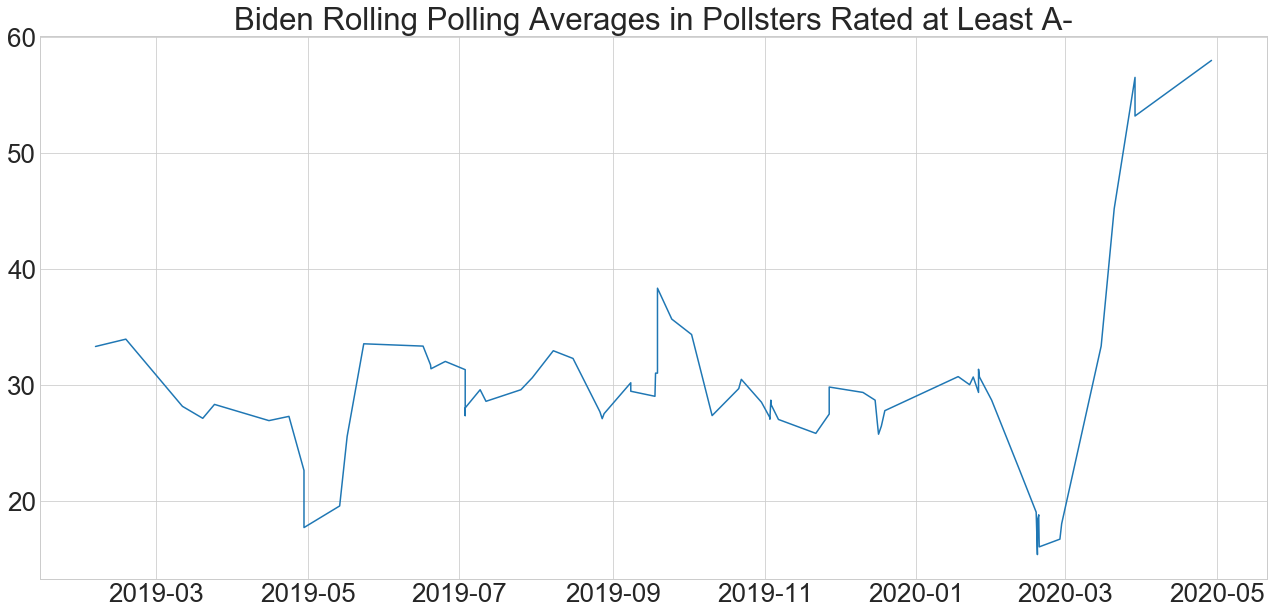

In [10]:
plt.figure(figsize=(22, 10))
plt.rcParams.update({'font.size': 26})
plt.plot(biden["startDateTs"], biden["rolling_mean"])
plt.title("Biden Rolling Polling Averages in Pollsters Rated at Least A-")
plt.show()

In [11]:
bidenTups = buildTuples(biden)
ts = traces.TimeSeries(data= bidenTups)
bidenRegularized = ts.moving_average(100, pandas=True)

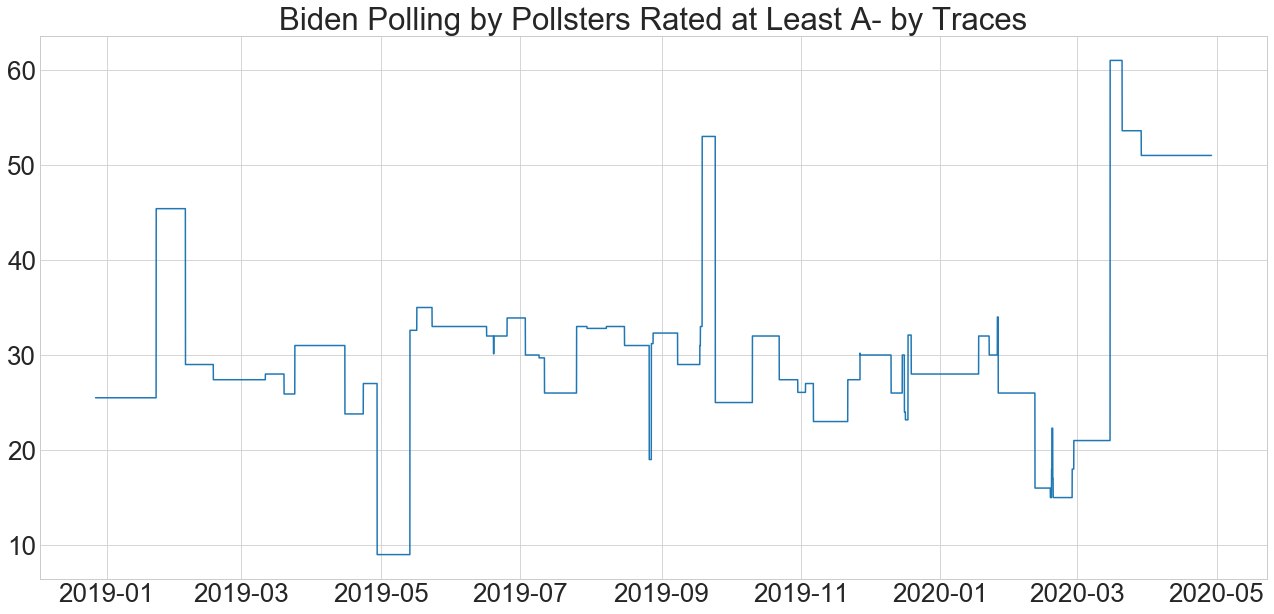

In [14]:
plt.figure(figsize=(22, 10))
plt.rcParams.update({'font.size': 26})
plt.plot(bidenRegularized.index, bidenRegularized.values)
plt.title("Biden Polling by Pollsters Rated at Least A- by Traces")
plt.show()

In [15]:
bidenDelta = delta(bidenRegularized)
bidenChangeDF = pd.DataFrame()
bidenChangeDF['change'] = bidenDelta
bidenChangeDF.index = bidenRegularized.index[1:]

# Preparing Training Data For Classifying Tweets
As we analyzed the 538 polling data for Biden, we will also build a classifier and test it using Twitter data about Biden.

In [16]:
bidenNeg = pd.read_csv("data/labels/biden_labels/biden_neg_train.csv")
bidenPos = pd.read_csv("data/labels/biden_labels/biden_pos_train.csv")
bidenNeu = pd.read_csv("data/labels/biden_labels/biden_neu_train.csv")
bidenTrain = pd.concat([bidenNeg, bidenPos, bidenNeu], ignore_index=True)
bidenTrain = bidenTrain[['text', 's_label']]

In [17]:
pipeline_sgd = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf',  TfidfTransformer()),
    ("lr", LogisticRegression(max_iter=1000))
])

# Classification

In [18]:
bidenFull = pd.read_csv("data/tweets_full/biden_full.csv")
model = pipeline_sgd.fit(bidenTrain['text'], bidenTrain['s_label'])
biden_predict = model.predict(bidenFull['text'])
bidenFull['sentiment'] = pd.Series(biden_predict)
ts = list()
for index, row in bidenFull.iterrows():
    try:
        ts.append(pd.to_datetime(row['date']))
    except:
        ts.append(0)
bad = 0
for i in range(0,len(ts)):
    if ts[i] == 0:
        ts[i] = ts[i-1]
bidenFull['ts'] = pd.Series(ts)
bidenFull['test']= pd.to_datetime(bidenFull['ts']) - pd.to_timedelta(7, unit='d')
bid = bidenFull.groupby([pd.Grouper(key='test', freq='W-MON')])['sentiment'].mean().reset_index().sort_values('test')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


# Average Change in Sentiment Every Week

In [19]:
bidenChange = delta(bid['sentiment'])
bidenDF = pd.DataFrame(bidenChange)
bidenDF.loc[-1] = [np.nan]  # adding a row
bidenDF.index = bidenDF.index + 1  # shifting index
bidenDF = bidenDF.sort_index()  # sorting by index
bidenDF['time'] = bid['test']
bidenDF.columns = ['change', 'time']

Text(0.5, 0, 'Date')

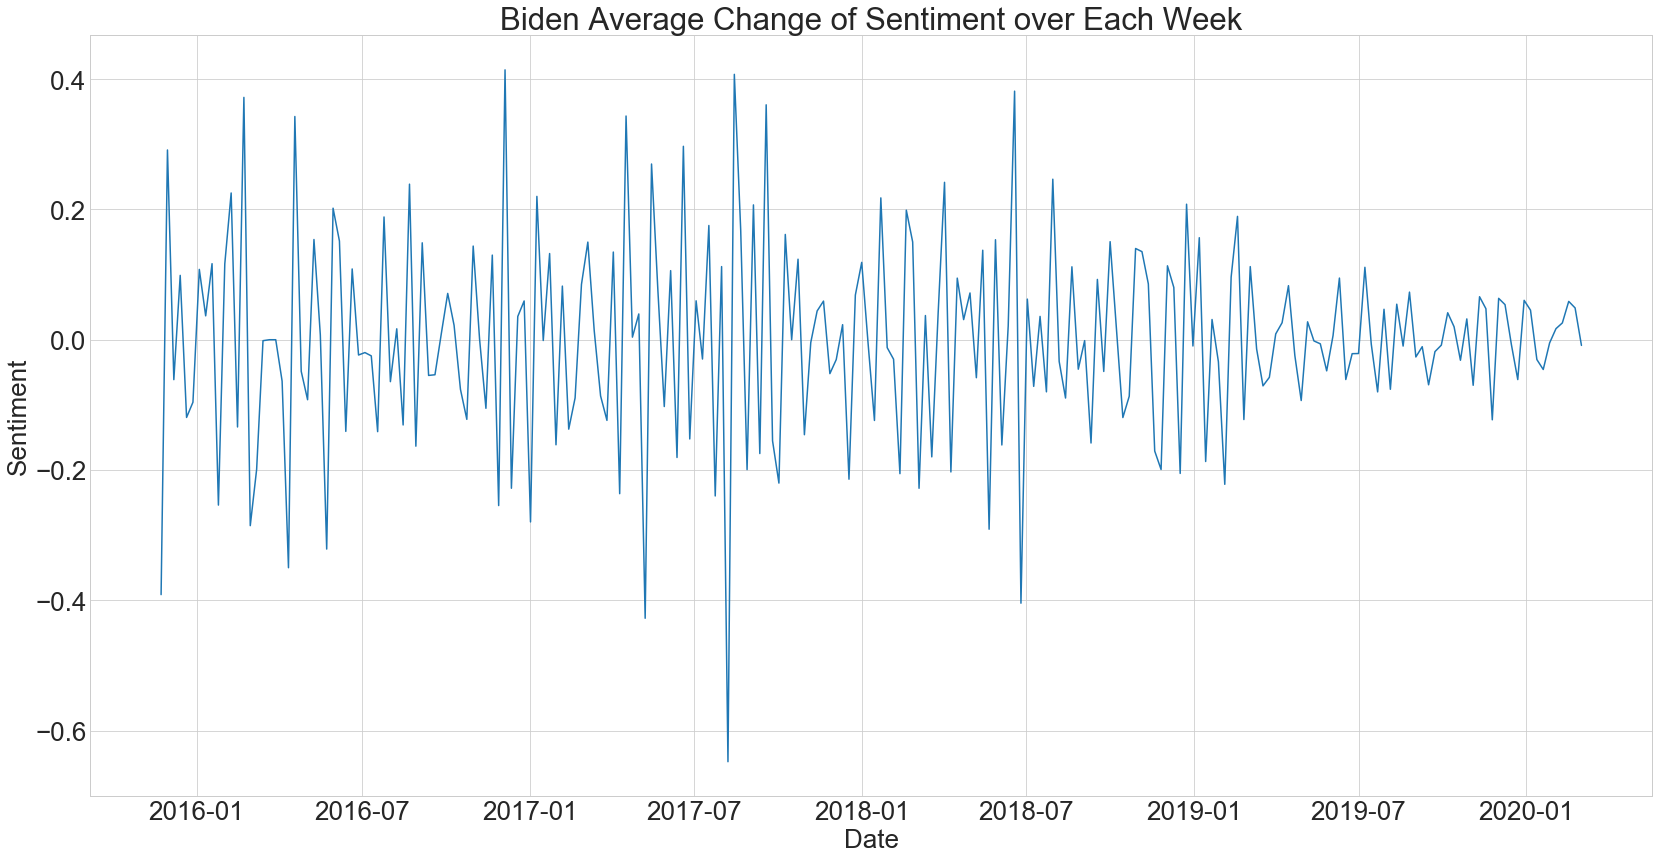

In [20]:
plt.figure(figsize=(28, 14))
ax = sns.lineplot(x=bidenDF["time"], y=bidenDF["change"], data=bidenDF)
plt.title("Biden Average Change of Sentiment over Each Week")
ax.set_ylabel("Sentiment")
ax.set_xlabel("Date")

# Correlations
Using 538 data once again.

In [21]:
bidenChangeDF['test']= bidenChangeDF.index - pd.to_timedelta(7, unit='d')
bidenDeltaGrouped = bidenChangeDF.groupby([pd.Grouper(key='test', freq='W-MON')])['change'].mean().reset_index().sort_values('test')

In [22]:
bidenChangeDF.index.year

Int64Index([2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018,
            ...
            2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020],
           dtype='int64', length=422173)

In [23]:
bidenDFScoped = bidenDF[bidenDF['time'] >= bidenChangeDF.index[0]]
bidenDFScoped = bidenDFScoped.reset_index()

In [24]:
bidenDeltaGrouped = bidenDeltaGrouped[1:].reset_index()
bidenDFScoped = bidenDFScoped.reset_index()
bidenDeltaGrouped = bidenDeltaGrouped.reset_index()

In [25]:
bidenCorr = pd.DataFrame()
bidenCorr['date'] = bidenDeltaGrouped['test'][1:]
bidenCorr['pollChanges'] = bidenDeltaGrouped['change'][1:]
bidenCorr['sentimentChanges'] = bidenDFScoped['change']

In [26]:
bidenCorr.corr(method ='pearson') 

,pollChanges,sentimentChanges
pollChanges,1.000000,0.024801
sentimentChanges,0.024801,1.000000
